In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import enchant
pd.set_option('display.max_rows', 500)

In [40]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

varcluster_info=pd.DataFrame(
{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
})

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100)]

In [33]:
df.head()

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription
0,GRK 6:&nbsp; Spatial Statistics,/gepris/projekt/268853,1997,2003,Mathematics,Technische Universität Bergakademie Freiberg,The work of the research training group is dir...,The work of the research training group is dir...,GRK 6:&nbsp; Spatial Statistics,work research training group direct model meth...
1,GRK 12:&nbsp; Migration in Modern Europe,/gepris/projekt/268931,1995,2004,Social Sciences,Universität Osnabrück,The subject of the research training group 'Mi...,The subject of the research training group 'Mi...,GRK 12:&nbsp; Migration in Modern Europe,subject research training group migration mode...
2,GRK 45:&nbsp; Integrated Fluidical Sensor-Actu...,/gepris/projekt/269237,1995,2004,Production Technology,Universität Rostock,The goal of this program consists in the mathe...,The goal of this program consists in the mathe...,GRK 45:&nbsp; Integrated Fluidical Sensor-Actu...,goal program consist mathematical formulation ...
3,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,/gepris/projekt/269303,1995,2004,Condensed Matter Physics,Universität Leipzig,The aim of the research training group is to p...,The aim of the research training group is to p...,GRK 52:&nbsp; Quantum Field Theory: Mathematic...,aim research training group pass generation sc...
4,GRK 115:&nbsp; Ocean Engineering Structures,/gepris/projekt/269869,1995,2004,Construction Engineering and Architecture,Technische Universität Hamburg,Ocean engineering encompasses a wide variety o...,Ocean engineering encompasses a wide variety o...,GRK 115:&nbsp; Ocean Engineering Structures,ocean engineering encompass wide variety area ...


In [3]:
merged_data=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")
merged_data=merged_data[pd.isnull(merged_data["Category"])==False]

In [4]:
dummies=pd.get_dummies(merged_data['Category'])
merged_data=pd.concat([merged_data,dummies], axis=1,ignore_index=False)

In [5]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(2, 2))
review_vectors = vectorizer.fit_transform(merged_data["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
merged_data.reset_index(drop=True, inplace=True)
merged_data=pd.concat([merged_data,features_df], axis=1,ignore_index=False)

wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

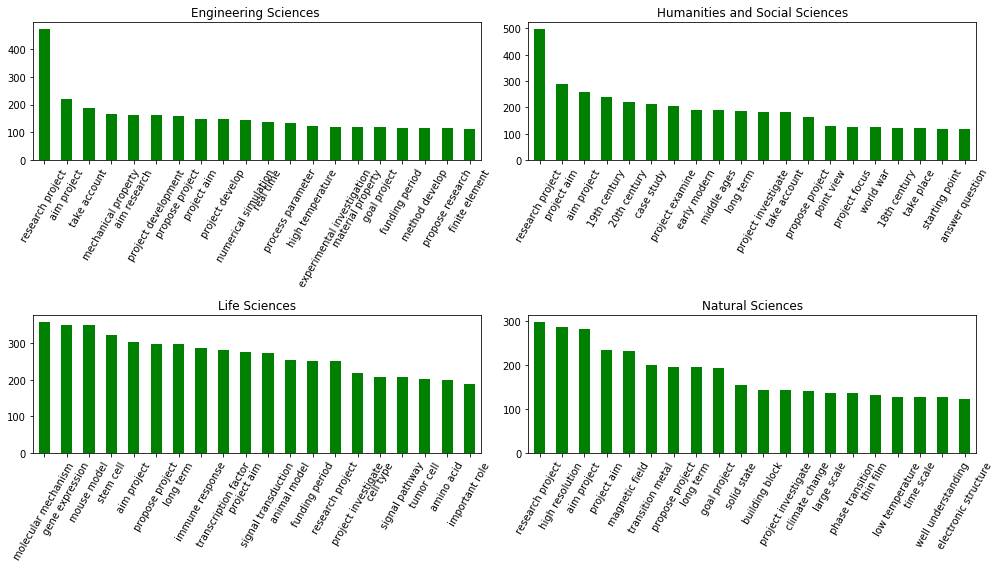

In [6]:
plt.subplots(figsize=(14,8)) 
i=1
for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    
    i=i+1
    plt.tight_layout()

In [7]:
pca = PCA(n_components=2).fit_transform(merged_data[merged_data.columns[16:]])
concated_ds=pd.concat([pd.DataFrame(pca),merged_data], ignore_index=True, axis=1)
concated_ds.columns=['PCA_1','PCA_2']+merged_data.columns.tolist()
merged_data=concated_ds

In [8]:
merged_data.Category=merged_data.Category.str.strip()

In [9]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varcluster=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')

In [10]:
## Removing the General cluster columns
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.category=='General'].Variable)])

In [11]:
## Removing the columns that are far away from of cluster
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.RS_Ratio>=1].Variable)])

In [ ]:
## Other variable cluster with same category analysis

#catfiltered_ds=merged_data[merged_data.Category=='Engineering Sciences ']
#othercolumns=merged_data.columns[~merged_data.columns.isin(varcluster[varcluster.category=='Engineering Sciences'].Variable)]
#merged_data[['Description','File_Categories','Category']].loc[catfiltered_ds[othercolumns[15:]].head().T.sum().index]

In [ ]:
#Filename='DBScanCluster.csv'
#NewMergedDS=pd.read_csv(Path+Filename)

In [12]:
merged_data.columns[18:].tolist()

['18th century',
 '19th century',
 '20th century',
 'ab initio',
 'achieve goal',
 'achieve high',
 'active site',
 'address question',
 'adhesion molecule',
 'adipose tissue',
 'advance understanding',
 'age relate',
 'aim analyze',
 'aim characterize',
 'aim contribute',
 'aim determine',
 'aim develop',
 'aim elucidate',
 'aim establish',
 'aim explore',
 'aim identify',
 'aim improve',
 'aim investigate',
 'aim investigation',
 'aim plan',
 'aim present',
 'aim project',
 'aim proposal',
 'aim propose',
 'aim provide',
 'aim research',
 'aim study',
 'aim subproject',
 'aim understand',
 'aim work',
 'allow study',
 'alzheimer disease',
 'amino acid',
 'analysis method',
 'analytical method',
 'animal model',
 'answer question',
 'anti inflammatory',
 'application later',
 'application period',
 'approach allow',
 'approach base',
 'approach combine',
 'approach develop',
 'arabidopsis thaliana',
 'area the',
 'associate protein',
 'atomic force',
 'attention pay',
 'autoimmune dis

In [13]:
for cat in merged_data.Category.unique():
    print('******'+cat+'******')
    FeatureCols=merged_data.columns[18:]
    CategoricalDS= merged_data[merged_data.Category==cat]

    for ps in np.linspace(500,500,1, dtype=int):
        pca =PCA(n_components=ps)
        pca_data= pd.DataFrame(pca.fit_transform(CategoricalDS[FeatureCols]))

        print('PCA components :',ps,'Variance coveragence' ,np.max(pca.explained_variance_ratio_.cumsum())*100)

        clusterer = DBSCAN(eps=.85, min_samples=15, n_jobs=4)
        preds = clusterer.fit_predict(pca_data)

        print(pd.Series(preds).value_counts())
        
        # = silhouette_score (pca_data, preds, metric='euclidean')
        #print("For n_clusters = {}, silhouette score is {}, Density {})".format(n_clusters, score,pd.Series(preds).value_counts().tolist()))
        #print(score)
    

******Natural Sciences******
PCA components : 500 Variance coveragence 87.37481554922387


KeyboardInterrupt: 

In [16]:
FeatureCols=merged_data.columns[18:]
comps=500
epsilon=.9#875
min_sample=15
print(str(datetime.datetime.now())+" : Started ")

CategoricalDS1=merged_data[merged_data.Category=='Engineering Sciences']

Features=CategoricalDS1[FeatureCols]
pca =PCA(n_components=comps)
pca_data1= pd.DataFrame(pca.fit_transform(Features))
DBScanDS1 = DBSCAN(eps=epsilon, min_samples=15, n_jobs=4).fit_predict(pca_data1)
CategoricalDS1['DBScanCluster']=DBScanDS1
pca_data1['DBScanCluster']=DBScanDS1
print('Engineering Sciences', CategoricalDS1['DBScanCluster'].value_counts())

CategoricalDS2=merged_data[merged_data.Category=='Humanities and Social Sciences']
Features=CategoricalDS2[FeatureCols]
pca =PCA(n_components=comps)
pca_data2= pd.DataFrame(pca.fit_transform(Features))
DBScanDS2 = DBSCAN(eps=epsilon, min_samples=15, n_jobs=4).fit_predict(pca_data2)
CategoricalDS2['DBScanCluster']=DBScanDS2
pca_data2['DBScanCluster']=DBScanDS2
print('Humanities and Social Sciences', CategoricalDS2['DBScanCluster'].value_counts())

CategoricalDS3=merged_data[merged_data.Category=='Life Sciences']
Features=CategoricalDS3[FeatureCols]
pca =PCA(n_components=comps)
pca_data3= pd.DataFrame(pca.fit_transform(Features))
DBScanDS3 = DBSCAN(eps=epsilon, min_samples=15, n_jobs=4).fit_predict(pca_data3)
CategoricalDS3['DBScanCluster']=DBScanDS3
pca_data3['DBScanCluster']=DBScanDS3
print('Life Sciences', CategoricalDS3['DBScanCluster'].value_counts())

CategoricalDS4=merged_data[merged_data.Category=='Natural Sciences']
Features=CategoricalDS4[FeatureCols]
pca =PCA(n_components=comps)
pca_data4= pd.DataFrame(pca.fit_transform(Features))
DBScanDS4 = DBSCAN(eps=epsilon, min_samples=15, n_jobs=4).fit_predict(pca_data4)
CategoricalDS4['DBScanCluster']=DBScanDS4
pca_data4['DBScanCluster']=DBScanDS4
print('Natural Sciences', CategoricalDS4['DBScanCluster'].value_counts())

NewMergedDS=pd.concat([CategoricalDS1,CategoricalDS2,CategoricalDS3,CategoricalDS4])
NewMergedPCADS=pd.concat([pca_data1,pca_data2,pca_data3,pca_data4])

NewMergedDS[NewMergedDS.columns[:14].tolist()+['DBScanCluster']].to_csv(Path+'DBScanClusterPCA.csv', index=False)

print(str(datetime.datetime.now())+" : Completed ")

2020-01-02 22:46:55.713055 : Started 


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Engineering Sciences  0    6680
-1    2708
 1      22
Name: DBScanCluster, dtype: int64


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Humanities and Social Sciences  0    7666
-1    2552
Name: DBScanCluster, dtype: int64


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Life Sciences  0    15532
-1     2669
Name: DBScanCluster, dtype: int64


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Natural Sciences  0    12062
-1     1648
 1      261
 2       14
Name: DBScanCluster, dtype: int64
2020-01-02 22:57:18.680875 : Completed 


In [17]:
#NewMergedDS.DBScanCluster.value_counts()
NewMergedDS['DBScanCluster'].value_counts()

 0    41940
-1     9577
 1      283
 2       14
Name: DBScanCluster, dtype: int64

In [18]:
NewMergedDS['Category'].value_counts()

Life Sciences                     18201
Natural Sciences                  13985
Humanities and Social Sciences    10218
Engineering Sciences               9410
Name: Category, dtype: int64

In [19]:
NewMergedPCADS[NewMergedPCADS.columns[:-1]]=NewMergedPCADS[NewMergedPCADS.columns[:-1]]+1
NewMergedDS=NewMergedDS.reset_index()[NewMergedDS.columns[0:]]

In [20]:
NewMergedDS['CategoryConv']=''
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Engineering Sciences']=0
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Humanities and Social Sciences']=1
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Natural Sciences']=2
NewMergedDS['CategoryConv'][NewMergedDS['Category']=='Life Sciences']=3

NewMergedDS['CategoryConv']=NewMergedDS['CategoryConv'].astype('int')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/U

In [21]:
#NewMergedDS.columns[18:len(NewMergedDS.columns)-1]

In [22]:
Features=NewMergedDS.columns[18:len(NewMergedDS.columns)-1]
OP_Feature='CategoryConv'

X_Training_DS=NewMergedDS[Features][NewMergedDS.DBScanCluster==0]
#X_Training_DS=NewMergedPCADS[NewMergedPCADS.DBScanCluster==0]
y_Training_DS=NewMergedDS[OP_Feature][NewMergedDS.DBScanCluster==0]

X_Test_DS=NewMergedDS[Features][NewMergedDS.DBScanCluster!=0]
#X_Test_DS=NewMergedPCADS[NewMergedPCADS.DBScanCluster!=0]
y_Test_DS=NewMergedDS[OP_Feature][NewMergedDS.DBScanCluster!=0]


X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)


Accuracy Score : 0.699928469241774


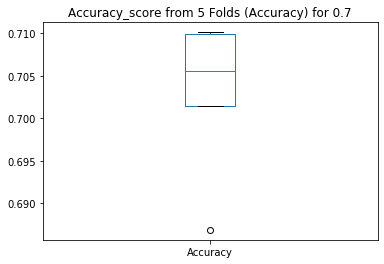

In [23]:
modelNB = MultinomialNB(alpha=1)
modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

In [24]:
modelKBC = KNeighborsClassifier(n_neighbors=20)
modelKBC.fit(X_train, y_train)

#nfolds=1
#y_pred = modelKBC.predict(X_test)
#print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )))
#scores=cross_val_score(modelKBC, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
#pd.Series(scores).plot(kind="box", label="Accuracy");
#plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [25]:
def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''

In [26]:
#matching_category()
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelNB.predict_log_proba(NewMergedDS[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

Engineering Sciences 2730
Natural Sciences                  286
Humanities and Social Sciences      2
Life Sciences                       1
Name: Category_1, dtype: int64

Humanities and Social Sciences 2552
Life Sciences       96
Natural Sciences     2
Name: Category_1, dtype: int64

Life Sciences 2669
Series([], Name: Category_1, dtype: int64)

Natural Sciences 1662
Engineering Sciences    11
Life Sciences            2
Name: Category_1, dtype: int64



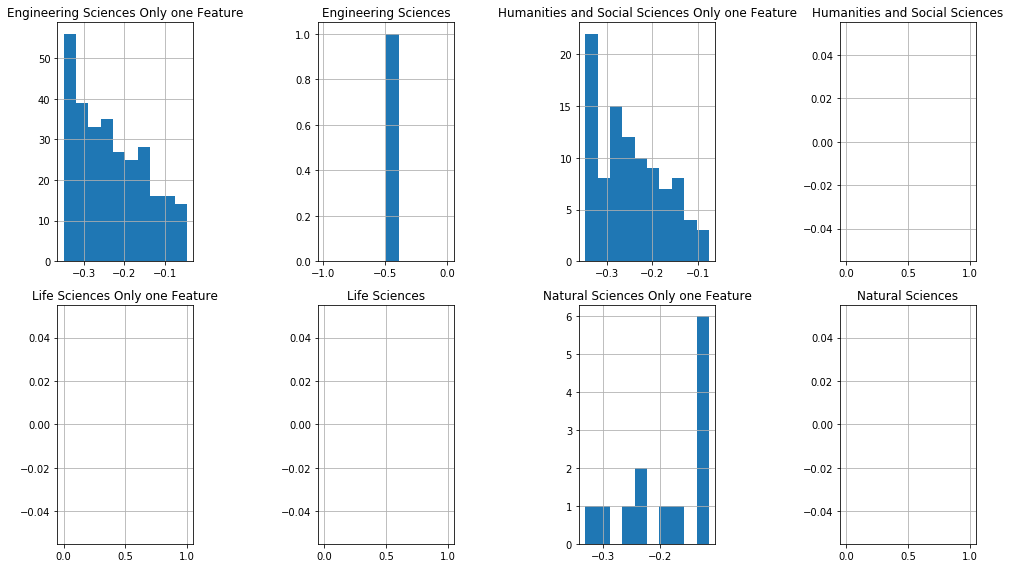

In [49]:
#& (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])
plt.subplots(figsize=(14,8)) 
j=1
for i,w in NewMergedDSAligned[(NewMergedDSAligned.DBScanCluster!=0) ].groupby(['Category']):
    print(i, w.count()['DBScanCluster'])
    print(w['Category_1'][(w['Category_1']!=i) & (w['Category_12_Variance']>0.5) & (w['Category_1_Values']>-0.35)].value_counts())
    print('')
    
    plt.subplot(2,4,j)
    w['Category_1_Values'][(w['Category_1']!=i) & (w['Category_12_Variance']>0.5) & (w['Category_1_Values']>-0.35)].hist()
    plt.title(i+' Only one Feature')
    
    j=j+1
    plt.subplot(2,4,j)
    w['Category_1_Values'][(w['Category_1']!=i) & (w['Category_12_Variance']<0.5)  & (w['Category_1_Values']>-0.5)].hist()
    plt.title(i)
    j=j+1
    
    plt.tight_layout()

    

In [27]:
NewMergedDSAligned=pd.concat([NewMergedDS[NewMergedDS.columns.tolist()[2:14]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [43]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    11744
-1     3407
 2       14
 1       14
Name: DBScanCluster, dtype: int64

In [39]:
NewMergedDSAligned=NewMergedDSAligned[NewMergedDSAligned['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

In [50]:
cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(100).tolist()#.tail().

['The hippocampal (HC) formation is a structure fundamentally important for episodic memory. However its exact functions have been underspecified due to the structural heterogeneity within the HC formation, posing technical difficulties for in vivo measurement in humans. Only recently advances in structural and functional high-resolution imaging have enabled research to document differential contributions of various hippocampal subfields to computational processes that are important for memory, including pattern separation and completion. In this context, pattern separation refers to computational operations that transform similar representations, for example derived from perception or memory, into highly dissimilar, non-overlapping representations. By contrast, pattern completion operations allow restoration of complete representations form partially available information. Initial evidence from age-comparative studies of healthy aged humans supports animal models of hippocampal aging,

In [51]:
#cats='Natural Sciences'
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(100)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
16889,The hippocampal (HC) formation is a structure ...,Humanities and Social Sciences,-0.075097,-3.290192,-3.701710,Life Sciences,Natural Sciences,Engineering Sciences,3.215095,0.411518
16622,Stress plays a major role in the development a...,Humanities and Social Sciences,-0.095432,-2.699296,-4.293699,Life Sciences,Natural Sciences,Humanities and Social Sciences,2.603864,1.594403
17155,Background: The relevance and prevalence of su...,Humanities and Social Sciences,-0.101336,-2.627571,-4.261463,Life Sciences,Humanities and Social Sciences,Natural Sciences,2.526235,1.633892
18725,"In addition to regular physical activity, smok...",Humanities and Social Sciences,-0.106820,-2.986987,-3.386813,Life Sciences,Humanities and Social Sciences,Natural Sciences,2.880167,0.399826
11222,"It is estimated that in the US, 17% of the pop...",Humanities and Social Sciences,-0.108440,-2.638982,-3.821458,Life Sciences,Humanities and Social Sciences,Natural Sciences,2.530542,1.182476
15702,Social contract theory postulates that highly ...,Humanities and Social Sciences,-0.119356,-2.974177,-3.117098,Life Sciences,Humanities and Social Sciences,Natural Sciences,2.854821,0.142921
15222,The proposed experiments will investigate the ...,Humanities and Social Sciences,-0.127227,-2.518062,-3.516170,Life Sciences,Natural Sciences,Humanities and Social Sciences,2.390836,0.998108
15638,Episodic memory (EG) is based on structural an...,Humanities and Social Sciences,-0.134962,-2.580143,-3.612474,Life Sciences,Natural Sciences,Humanities and Social Sciences,2.445180,1.032332
16723,Although cognitive behavioral therapy constitu...,Humanities and Social Sciences,-0.140073,-2.658368,-2.907441,Life Sciences,Humanities and Social Sciences,Natural Sciences,2.518295,0.249073
16209,Auditory perception is not a purely stimulus-d...,Humanities and Social Sciences,-0.141095,-2.710854,-2.980015,Life Sciences,Natural Sciences,Humanities and Social Sciences,2.569758,0.269162


In [ ]:
#NewMergedDS[NewMergedDS.columns.tolist()[2:16]].head()
NewMergedDSAligned[NewMergedDSAligned.columns.tolist()[6:]].head()

In [ ]:
NewMergedDSAligned.to_csv(Path+'DBScanNBFindingsPCA.csv', index=False)

In [ ]:
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(40).tolist()#.tail().

In [ ]:
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(40)#.tail()

In [ ]:
NewMergedDSAligned[['Translates','Category_12_Variance']][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_12_Variance', ascending=False).Translates.head(5).tail().tolist()

In [ ]:
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[15:].tolist()][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_12_Variance', ascending=False).head(5).tail()